# Transformer encoder for text classification

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import backend as K
import numpy as np
import os, pathlib, shutil, random
import shutil
import seaborn as sns

2023-05-22 10:44:00.483470: E tensorflow/core/lib/monitoring/collection_registry.cc:77] Cannot register 2 metrics with the same name: /tensorflow/core/saved_model/write/count
2023-05-22 10:44:00.483584: E tensorflow/core/lib/monitoring/collection_registry.cc:77] Cannot register 2 metrics with the same name: /tensorflow/core/saved_model/read/count
2023-05-22 10:44:00.483612: E tensorflow/core/lib/monitoring/collection_registry.cc:77] Cannot register 2 metrics with the same name: /tensorflow/core/saved_model/write/api
2023-05-22 10:44:00.483625: E tensorflow/core/lib/monitoring/collection_registry.cc:77] Cannot register 2 metrics with the same name: /tensorflow/core/saved_model/read/api


### Dataset Imdb for sentences binary classification

In [ ]:
# Download the dataset

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

shutil.rmtree('aclImdb/train/unsup')

In [3]:
# Create a validation set with the 20% of training data

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files) 
    num_val_samples = int(0.2 * len(files)) 
    val_files = files[-num_val_samples:] 
    for fname in val_files: 
        shutil.move(train_dir / category / fname, val_dir / category / fname)

In [2]:
# Prepare datasets that return integers sequences

batch_size = 32
train_ds = keras.utils.text_dataset_from_directory( "aclImdb/train", batch_size=batch_size)
val_ds = keras.utils.text_dataset_from_directory("aclImdb/val", batch_size=batch_size)
test_ds = keras.utils.text_dataset_from_directory("aclImdb/test", batch_size=batch_size)

text_only_train_ds = train_ds.map(lambda x, y: x) 

max_length = 600
max_tokens = 20000
text_vectorization = TextVectorization(
 max_tokens=max_tokens,
 output_mode="int",
 output_sequence_length=max_length, 
)
text_vectorization.adapt(text_only_train_ds)
int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)

Found 25000 files belonging to 2 classes.


2023-05-22 10:44:04.521617: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


2023-05-22 10:44:06.477920: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:164] None of the MLIR Optimization Passes are enabled (registered 2)


In [ ]:
print(list(int_test_ds)[:32])

In [4]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim 
        self.dense_dim = dense_dim 
        self.num_heads = num_heads 
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"),layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None): 
        if mask is not None: 
            mask = mask[:, tf.newaxis, :] 
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    
    def get_config(self): 
        config = super().get_config()
        config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
        })
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs): 
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim) 
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
    
    def compute_mask(self, inputs, mask=None): 
        return tf.math.not_equal(inputs, 0) 
    
    def get_config(self): 
        config = super().get_config()
        config.update({
        "output_dim": self.output_dim,
        "sequence_length": self.sequence_length,
        "input_dim": self.input_dim,
        })
        return config

In [5]:
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

In [10]:
inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs) 
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="adam",
 loss="binary_crossentropy",
 metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
print(model.weights)

In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint("encoder_model/full_transformer_encoder.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
] 
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, 
callbacks=callbacks)

Epoch 1/20
625/625 [==============================] - 351s 561ms/step - loss: 0.4607 - binary_accuracy: 0.7852 - val_loss: 0.2795 - val_binary_accuracy: 0.8856
Epoch 2/20
625/625 [==============================] - 343s 549ms/step - loss: 0.1673 - binary_accuracy: 0.9359 - val_loss: 0.3388 - val_binary_accuracy: 0.8702
Epoch 3/20
625/625 [==============================] - 342s 548ms/step - loss: 0.0798 - binary_accuracy: 0.9718 - val_loss: 0.4555 - val_binary_accuracy: 0.8672
Epoch 4/20
625/625 [==============================] - 345s 553ms/step - loss: 0.0548 - binary_accuracy: 0.9805 - val_loss: 0.4925 - val_binary_accuracy: 0.8638


In [6]:
model = keras.models.load_model(
    "encoder_model/full_transformer_encoder.h5",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})

<AxesSubplot:ylabel='Frequency'>

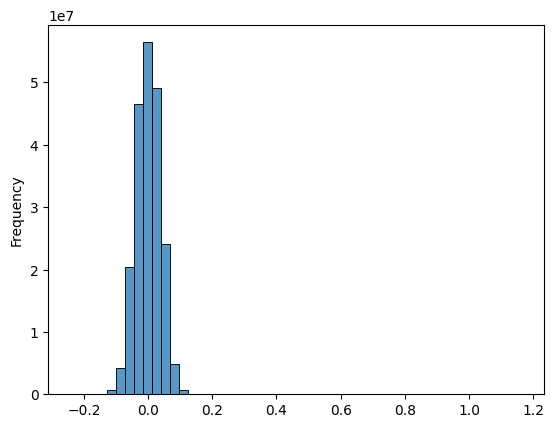

In [8]:
weights = model.get_weights()
flattened_weights = [w.flatten() for w in weights]
weights_array = [item for sublist in flattened_weights for item in sublist]
sns.histplot(weights_array, stat='frequency', bins=50)

In [14]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
positional_embedding (Positi (None, None, 256)         5273600   
_________________________________________________________________
transformer_encoder (Transfo (None, None, 256)         543776    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 5,817,633
Trainable params: 5,817,633
Non-trainable params: 0
___________________________________________________

Evaluate the model accuracy with Float32 default weights

In [15]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 157s 201ms/step - loss: 0.3013 - binary_accuracy: 0.8748
Test acc: 0.875


In [22]:
print(f"Test acc: {model.evaluate(int_test_ds, steps=128)[1]:.3f}")

128/128 [==============================] - 25s 198ms/step - loss: 0.2917 - binary_accuracy: 0.8796
Test acc: 0.880


Evaluate the model accuracy converting the weights to Float16

In [16]:
K.set_floatx('float16')

# Get the original weights
ws = model.get_weights()
print(np.unique([w.dtype for w in model.get_weights()]))

[dtype('float32')]


In [17]:
# Convert the weights to Posit <16,0> and load a new model
wsp = [w.astype(K.floatx()) for w in ws]

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs) 
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_float16 = keras.Model(inputs, outputs)
model_float16.compile(optimizer="adam",
 loss="binary_crossentropy",
 metrics=["accuracy"])
model_float16.set_weights(wsp)

print(np.unique([w.dtype for w in model_float16.get_weights()]))

[dtype('float16')]


In [18]:
print(f"Test acc: {model_float16.evaluate(int_test_ds, steps=128)[1]:.3f}")

128/128 [==============================] - 2373s 19s/step - loss: 0.2893 - accuracy: 0.8789
Test acc: 0.879


In [ ]:
model_float16.save("encoder_model/test_float16.h5")

Evaluate the model accuracy converting the weights to Posit<16,0>

In [7]:
K.set_floatx('posit160')

# Get the original weights
ws = model.get_weights()
print(np.unique([w.dtype for w in model.get_weights()]))

[dtype('float32')]


In [8]:
# Convert the weights to Posit <16,0> and load a new model
wsp = [w.astype(K.floatx()) for w in ws]

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs) 
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_posit = keras.Model(inputs, outputs)
model_posit.compile(optimizer="adam",
 loss="binary_crossentropy",
 metrics=["accuracy"])
model_posit.set_weights(wsp)

print(np.unique([w.dtype for w in model_posit.get_weights()]))

[dtype(posit160)]


In [9]:
print(f"Test acc: {model_posit.evaluate(int_test_ds, steps=128)[1]:.3f}")

128/128 [==============================] - 7244s 57s/step - loss: 0.3354 - accuracy: 0.8525


In [ ]:
model_posit.save("encoder_model/test_posit160.h5")

Evaluate the model converting the input from int to posit<16,0>

In [11]:
int_test_ds = int_test_ds.map(lambda x, y: (tf.cast(x, tf.posit160), tf.cast(y, tf.posit160)))
print(list(int_test_ds)[0])

(<tf.Tensor: shape=(32, 600), dtype=posit160, numpy=
array([[503, 19, 52, ..., 0, 0, 0],
       [10, 274, 11, ..., 0, 0, 0],
       [10, 472, 10, ..., 0, 0, 0],
       ...,
       [58, 58, 58, ..., 0, 0, 0],
       [1, 7, 230, ..., 0, 0, 0],
       [10, 90, 449, ..., 0, 0, 0]], dtype=posit160)>, <tf.Tensor: shape=(32,), dtype=posit160, numpy=
array([1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1], dtype=posit160)>)


In [12]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 156s 200ms/step - loss: 0.4179 - binary_accuracy: 0.8120
Test acc: 0.812


In [13]:
print(f"Test acc: {model.evaluate(int_test_ds, steps=128)[1]:.3f}")

128/128 [==============================] - 26s 205ms/step - loss: 0.4195 - binary_accuracy: 0.8066
Test acc: 0.807
